In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.signal import square
from scipy.signal import sawtooth
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Simulation

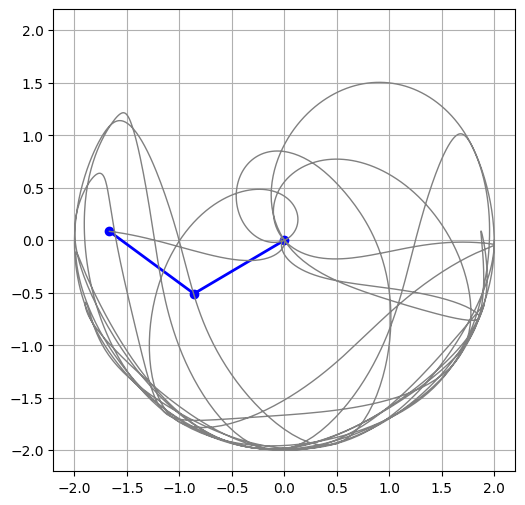

In [2]:

g = 9.81
L1 = 1.0
L2 = 1.0
m1 = 1.0
m2 = 1.0


def torque_input(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N.m
    return amplitude * square(2 * np.pi * freq * t)

def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
        m2 * g * np.sin(theta2) * np.cos(delta) +
        m2 * L2 * omega2**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta1) +
        tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
        (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
        (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]


y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 2000)


sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1, omega1, theta2, omega2 = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

# Coordinates
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)


fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2, color='blue')
trace, = ax.plot([], [], '-', lw=1, color='gray')
history_x, history_y = [], []

def init():
    line.set_data([], [])
    trace.set_data([], [])
    return line, trace

def update(frame):
    thisx = [0, x1[frame], x2[frame]]
    thisy = [0, y1[frame], y2[frame]]
    line.set_data(thisx, thisy)

    history_x.append(x2[frame])
    history_y.append(y2[frame])
    trace.set_data(history_x, history_y)
    return line, trace

ani = animation.FuncAnimation(fig, update, frames=len(t_eval),
                              init_func=init, blit=True, interval=20)

HTML(ani.to_html5_video())



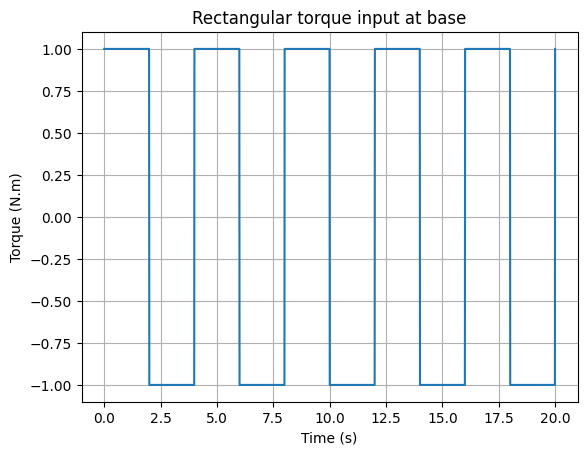

In [5]:
plt.figure()
torque_t = [torque_input(t) for t in t_eval]
plt.plot(t_eval, torque_t)
plt.title("Rectangular torque input at base")
plt.xlabel("Time (s)")
plt.ylabel("Torque (N.m)")
plt.grid()
plt.show()


# Data Preprocessing

In [168]:

X = np.column_stack((
    torque_t[1:],
    theta1[:-1], omega1[:-1],
    theta2[:-1], omega2[:-1]
))

Y = np.column_stack((
    theta1[1:], omega1[1:],
    theta2[1:], omega2[1:]
))

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]


scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)


# MLP

In [ ]:

X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_scaled, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_size=5, hidden_size=256, output_size=4):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)


model = MLP()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)




Epoch [10/200], Loss: 0.959812
Epoch [20/200], Loss: 0.959090
Epoch [30/200], Loss: 0.964417
Epoch [40/200], Loss: 0.959746
Epoch [50/200], Loss: 0.958797
Epoch [60/200], Loss: 0.961268
Epoch [70/200], Loss: 0.959483
Epoch [80/200], Loss: 0.959095
Epoch [90/200], Loss: 0.958688
Epoch [100/200], Loss: 0.957925
Epoch [110/200], Loss: 0.957086
Epoch [120/200], Loss: 0.959761
Epoch [130/200], Loss: 0.959206
Epoch [140/200], Loss: 0.958826
Epoch [150/200], Loss: 0.958121
Epoch [160/200], Loss: 0.958085
Epoch [170/200], Loss: 0.959541
Epoch [180/200], Loss: 0.958466
Epoch [190/200], Loss: 0.958610
Epoch [200/200], Loss: 0.957558


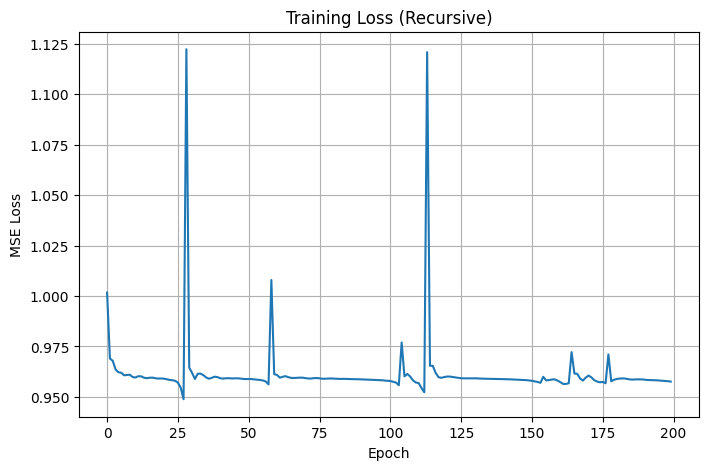

In [ ]:
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Initialize the first input (t=0)
    X_rec = X_train_scaled[0].copy().reshape(1, -1)

    preds_scaled = []

    for t in range(len(X_train_scaled)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)

        Y_pred_scaled = model(X_rec_torch)
        preds_scaled.append(Y_pred_scaled)

        if t < len(X_train_scaled) - 1:
            next_torque = X_train_scaled[t + 1, 0].reshape(1, 1)
            Y_pred_np = Y_pred_scaled.detach().numpy()
            X_rec = np.concatenate([next_torque, Y_pred_np], axis=1)

    preds_scaled = torch.cat(preds_scaled, dim=0)

    Y_train_torch_seq = torch.tensor(Y_train_scaled, dtype=torch.float32)

    loss = criterion(preds_scaled, Y_train_torch_seq)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

plt.figure(figsize=(8,5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss (Recursive)')
plt.grid(True)
plt.show()


In [ ]:

torch.save(model.state_dict(), '/content/drive/MyDrive/mlp_model.pth')

In [ ]:
model = MLP()
model.load_state_dict(torch.load('/content/drive/MyDrive/mlp_model.pth'))
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)

## test
as it was obvious, MLP has poor performance for modeling a dynamic system because of lack of memory in this kind of network architecture.
Loss: 0.957558

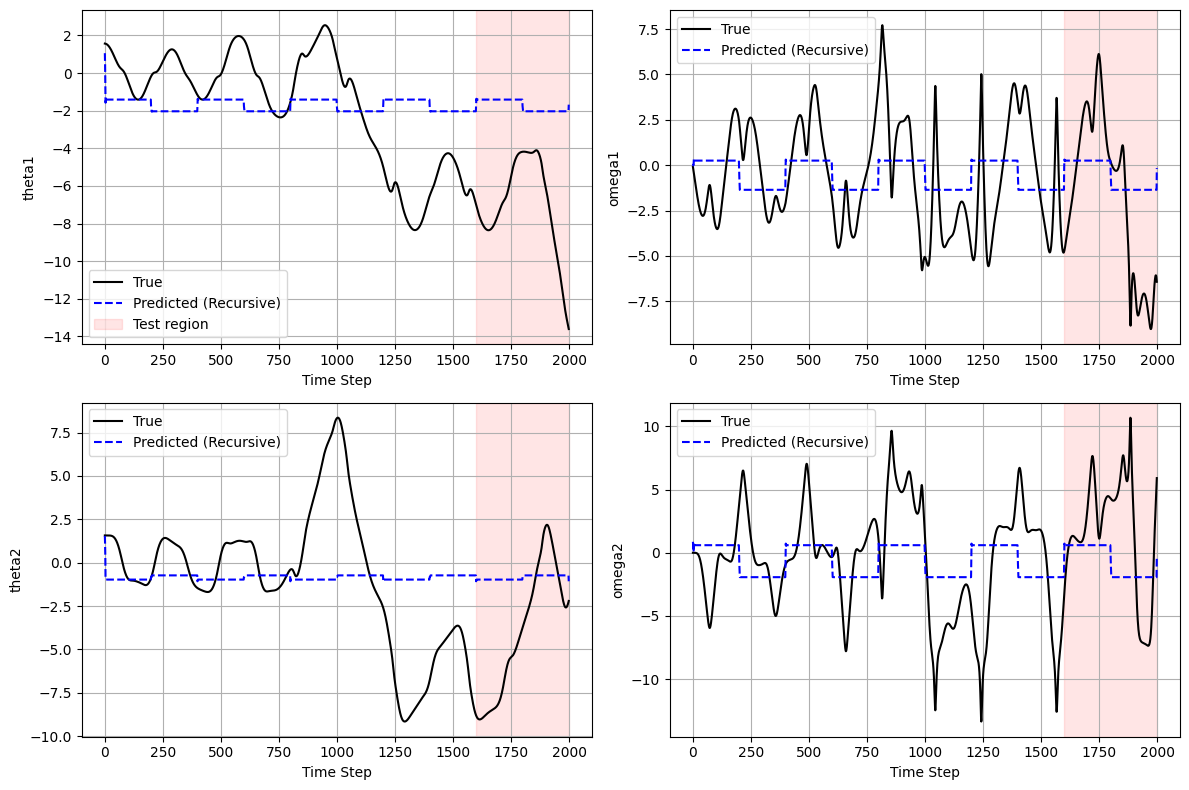

In [ ]:


X_scaled_all = np.vstack([X_train_scaled, X_test_scaled])
Y_scaled_all = np.vstack([Y_train_scaled, Y_test_scaled])

X_rec = X_scaled_all[0].copy().reshape(1, -1)

Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for t in range(len(X_scaled_all)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)
        Y_pred_scaled = model(X_rec_torch).numpy().flatten()

        Y_preds_scaled.append(Y_pred_scaled)

        if t < len(X_scaled_all) - 1:
            next_torque = X_scaled_all[t + 1, 0].reshape(1, 1)
            next_input = np.concatenate([next_torque, Y_pred_scaled.reshape(1, -1)], axis=1)
            X_rec = next_input

Y_preds_scaled = np.array(Y_preds_scaled)

Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)
Y_true = scaler_Y.inverse_transform(Y_scaled_all)

plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']
time_all = np.arange(len(Y_true))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time_all, Y_true[:, i], label='True', color='black')
    plt.plot(time_all, Y_preds[:, i], '--', label='Predicted (Recursive)', color='blue')

    plt.axvspan(split_idx, len(Y_true)-1, color='red', alpha=0.1, label='Test region' if i == 0 else None)

    plt.xlabel('Time Step')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## Sawtooth signal Test
here i tested the performance of this network in response to another typr of input torque. MLP had poor performance on train and test data so it is obvious that it will have the same poor performance here.

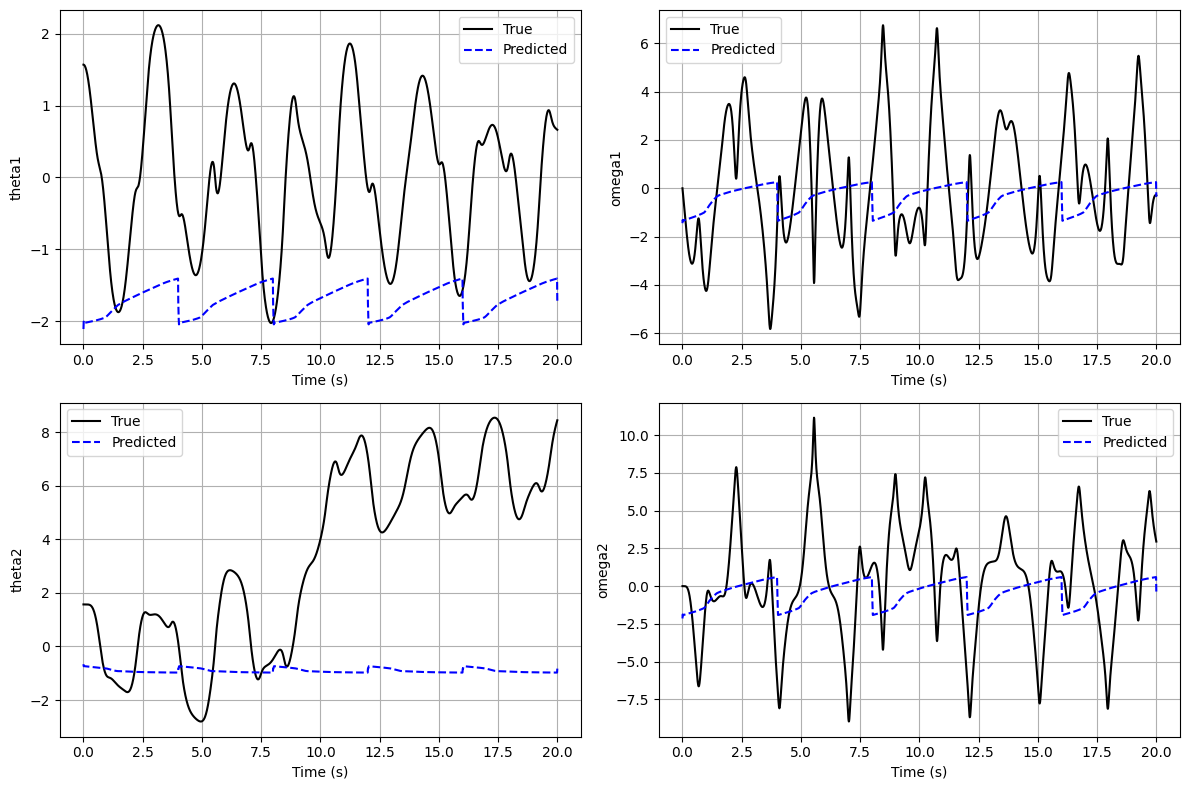

In [ ]:


def torque_input_s(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N.m
    return amplitude * sawtooth(2 * np.pi * freq * t)

def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input_s(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
        m2 * g * np.sin(theta2) * np.cos(delta) +
        m2 * L2 * omega2**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta1) +
        tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
        (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
        (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]

y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)
sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1s, omega1s, theta2s, omega2s = sol.y
Y_true = np.column_stack([theta1s, omega1s, theta2s, omega2s])

torque_vals = torque_input_s(t_eval)

X_rec = np.concatenate([[[torque_vals[0]]], [y0]], axis=1)
X_rec = scaler_X.transform(X_rec)

Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for i in range(len(t_eval)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)
        Y_pred_scaled = model(X_rec_torch).numpy().flatten()
        Y_preds_scaled.append(Y_pred_scaled)

        if i < len(t_eval) - 1:
            next_torque = torque_vals[i + 1]
            next_state = scaler_Y.inverse_transform(Y_pred_scaled.reshape(1, -1)).flatten()
            next_input = np.concatenate([[next_torque], next_state]).reshape(1, -1)
            X_rec = scaler_X.transform(next_input)

Y_preds_scaled = np.array(Y_preds_scaled)
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)


plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(t_eval, Y_true[:, i], color='black', label='True')
    plt.plot(t_eval, Y_preds[:, i], '--', color='blue', label='Predicted')
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# CNN

In [23]:
# ==== CNN Model Definition ====

class CNN(nn.Module):
    def __init__(self,
                 input_features=5,      # torque, theta1, omega1, theta2, omega2
                 output_size=4,         # predict theta1, omega1, theta2, omega2
                 history_len=100,        # number of past time steps used
                 conv_channels=[32, 64],  # list of channels for each conv layer
                 kernel_size=3):        # kernel size for conv layers
        super(CNN, self).__init__()

        layers = []
        in_channels = input_features
        for out_channels in conv_channels:
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2))
            layers.append(nn.ReLU())
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        self.flattened_size = conv_channels[-1] * history_len
        self.fc = nn.Linear(self.flattened_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, history_len, input_features)
        x = x.permute(0, 2, 1)  # -> (batch_size, input_features, history_len)
        x = self.conv(x)        # -> (batch_size, conv_channels[-1], history_len)
        x = x.view(x.size(0), -1)  # flatten
        return self.fc(x)       # -> (batch_size, output_size)

model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)


## Train

Epoch [10/200], Loss: 0.862422
Epoch [20/200], Loss: 0.837220
Epoch [30/200], Loss: 0.811732
Epoch [40/200], Loss: 0.767808
Epoch [50/200], Loss: 0.747278
Epoch [60/200], Loss: 0.754881
Epoch [70/200], Loss: 0.770952
Epoch [80/200], Loss: 0.809708
Epoch [90/200], Loss: 0.832970
Epoch [100/200], Loss: 0.800377
Epoch [110/200], Loss: 0.771780
Epoch [120/200], Loss: 0.559839
Epoch [130/200], Loss: 0.943703
Epoch [140/200], Loss: 0.873560
Epoch [150/200], Loss: 0.851689
Epoch [160/200], Loss: 0.813256
Epoch [170/200], Loss: 0.782620
Epoch [180/200], Loss: 0.741030
Epoch [190/200], Loss: 0.730942
Epoch [200/200], Loss: 0.629798


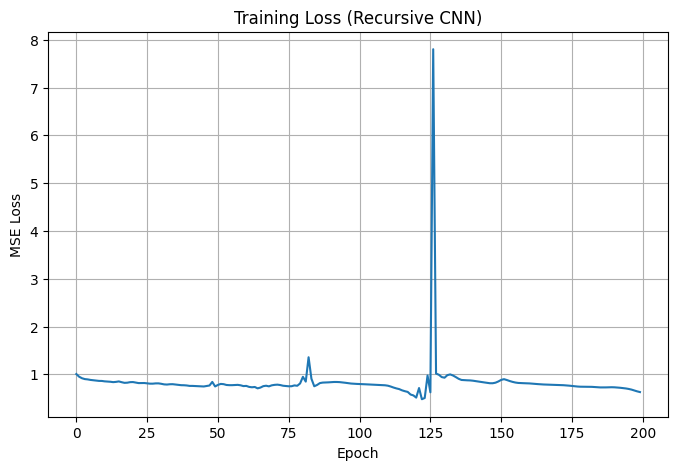

In [24]:

num_epochs = 200
history_len = 100
train_losses = []

# Pad beginning with first sample repeated for warm-up history
initial_window = np.tile(X_train_scaled[0], (history_len, 1))  # shape (15, 5)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    preds_scaled = []
    history = initial_window.copy()

    for t in range(len(X_train_scaled)):
        input_window = torch.tensor(history[-history_len:], dtype=torch.float32).unsqueeze(0)  # shape: (1, 15, 5)

        pred_scaled = model(input_window)
        preds_scaled.append(pred_scaled)

        if t < len(X_train_scaled) - 1:
            next_torque = X_train_scaled[t + 1, 0].reshape(1, 1)
            pred_np = pred_scaled.detach().numpy().reshape(1, -1)
            new_row = np.concatenate([next_torque, pred_np], axis=1)
            history = np.vstack([history, new_row])

    preds_scaled = torch.cat(preds_scaled, dim=0)
    Y_train_torch_seq = torch.tensor(Y_train_scaled, dtype=torch.float32)

    loss = criterion(preds_scaled, Y_train_torch_seq)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss (Recursive CNN)")
plt.grid(True)
plt.show()


## Test

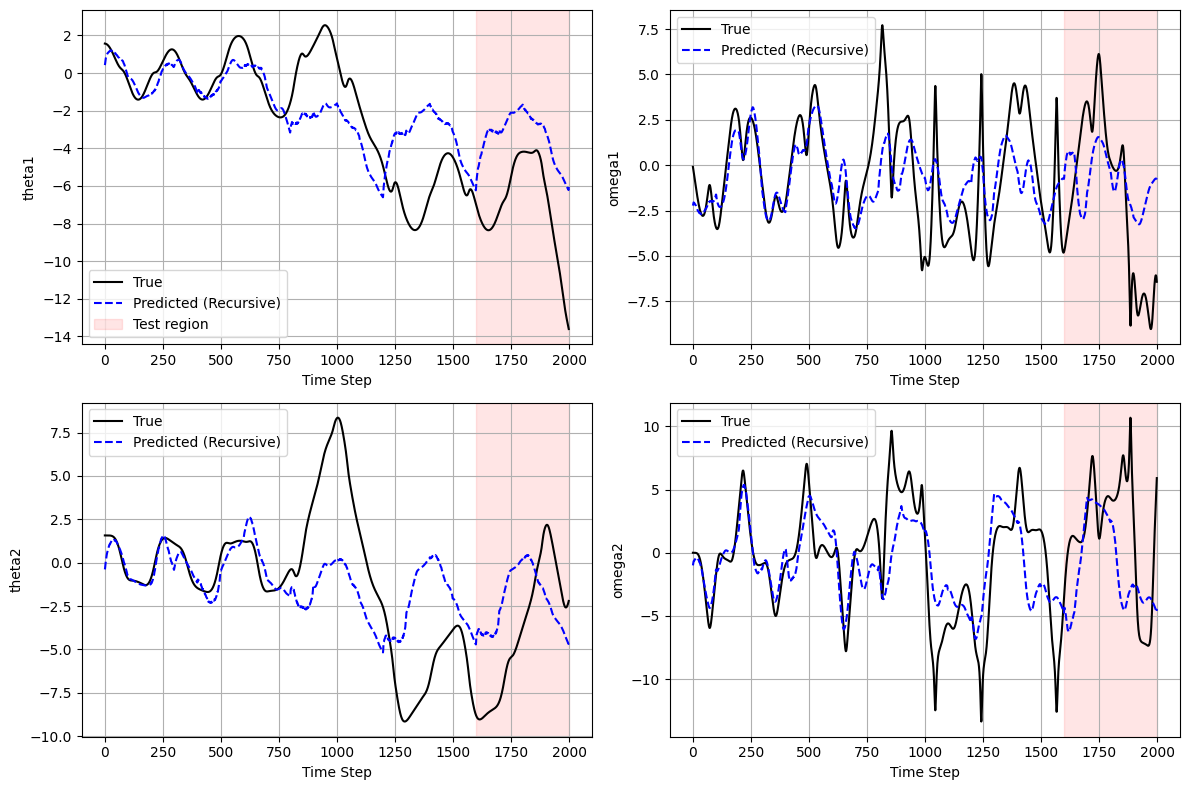

In [25]:
X_scaled_all = np.vstack([X_train_scaled, X_test_scaled])
Y_scaled_all = np.vstack([Y_train_scaled, Y_test_scaled])

initial_window = np.tile(X_scaled_all[0], (history_len, 1))  # (15, 5)
history = initial_window.copy()
Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for t in range(len(X_scaled_all)):
        input_window = torch.tensor(history[-history_len:], dtype=torch.float32).unsqueeze(0)  # (1, 15, 5)
        pred_scaled = model(input_window).numpy().flatten()
        Y_preds_scaled.append(pred_scaled)

        if t < len(X_scaled_all) - 1:
            next_torque = X_scaled_all[t + 1, 0].reshape(1, 1)
            new_input = np.concatenate([next_torque, pred_scaled.reshape(1, -1)], axis=1)
            history = np.vstack([history, new_input])

Y_preds_scaled = np.array(Y_preds_scaled)
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)
Y_true = scaler_Y.inverse_transform(Y_scaled_all)

# Plotting
plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']
time_all = np.arange(len(Y_true))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time_all, Y_true[:, i], label='True', color='black')
    plt.plot(time_all, Y_preds[:, i], '--', label='Predicted (Recursive)', color='blue')
    plt.axvspan(split_idx, len(Y_true) - 1, color='red', alpha=0.1, label='Test region' if i == 0 else None)
    plt.xlabel('Time Step')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
save_path = '/content/drive/MyDrive/cnn_moddel.pth'
torch.save(model.state_dict(), save_path)
print(f'Model saved to {save_path}')

Model saved to /content/drive/MyDrive/cnn_moddel.pth


In [29]:

save_path = '/content/drive/MyDrive/cnn_moddel.pth'
model = CNN(
    input_features=5,
    output_size=4,
    history_len=history_len,
    conv_channels=[32, 64],
    kernel_size=3
)

# Load the saved weights
model.load_state_dict(torch.load(save_path))
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


## Sawtooth signal Test

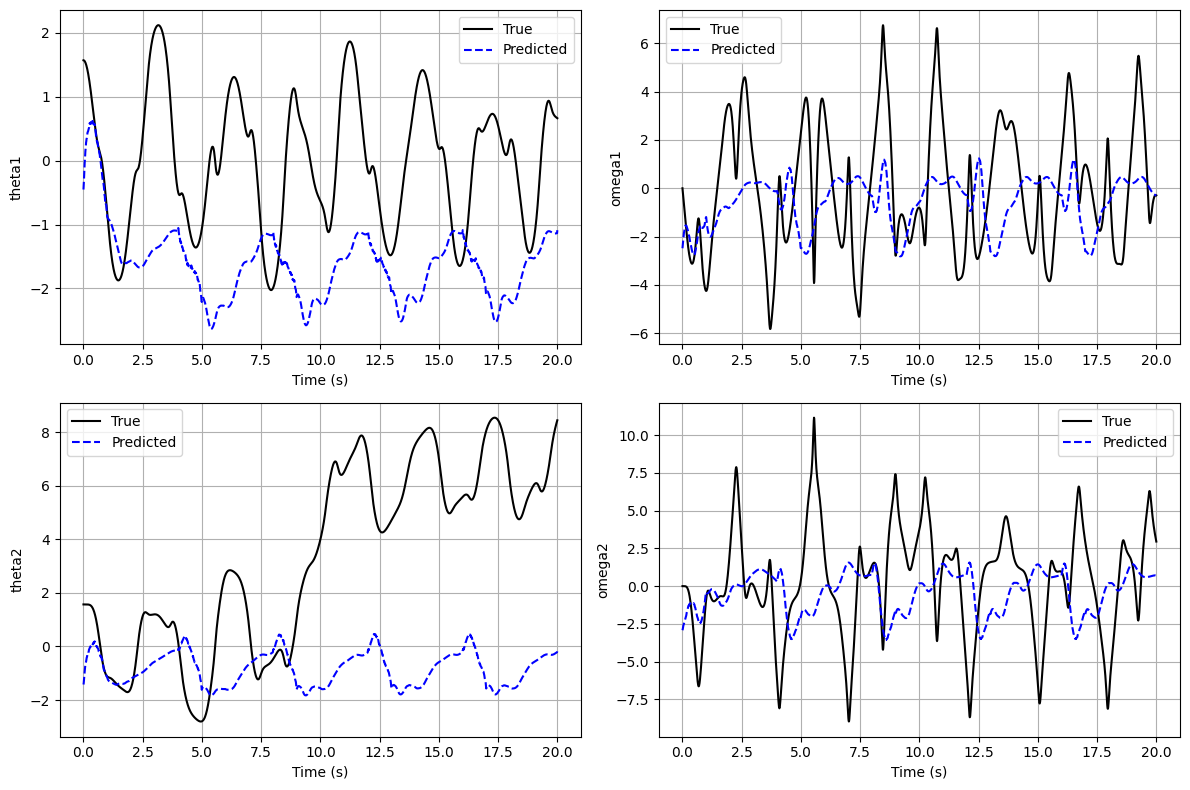

In [30]:

# Generate sawtooth torque signal
def torque_input_s(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N.m
    return amplitude * sawtooth(2 * np.pi * freq * t)

# Define the system
def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input_s(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
        m2 * g * np.sin(theta2) * np.cos(delta) +
        m2 * L2 * omega2**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta1) +
        tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
        (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
        (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]

# Time and initial condition
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)
y0 = [np.pi / 2, 0, np.pi / 2, 0]

# Solve ODE for ground truth
sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1s, omega1s, theta2s, omega2s = sol.y
Y_true = np.column_stack([theta1s, omega1s, theta2s, omega2s])
torque_vals = torque_input_s(t_eval)

# Prepare initial history
initial_state = np.concatenate([[torque_vals[0]], y0])
initial_state_scaled = scaler_X.transform(initial_state.reshape(1, -1))
history = np.repeat(initial_state_scaled, history_len, axis=0)  # shape: (history_len, 5)

Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for i in range(len(t_eval)):
        input_window = torch.tensor(history[-history_len:], dtype=torch.float32).unsqueeze(0)  # (1, history_len, 5)
        pred_scaled = model(input_window).numpy().flatten()
        Y_preds_scaled.append(pred_scaled)

        if i < len(t_eval) - 1:
            next_torque = torque_vals[i + 1]
            next_state_unscaled = scaler_Y.inverse_transform(pred_scaled.reshape(1, -1)).flatten()
            next_input = np.concatenate([[next_torque], next_state_unscaled]).reshape(1, -1)
            next_input_scaled = scaler_X.transform(next_input)
            history = np.vstack([history, next_input_scaled])

Y_preds_scaled = np.array(Y_preds_scaled)
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)

# === Plot Results ===
plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(t_eval, Y_true[:, i], color='black', label='True')
    plt.plot(t_eval, Y_preds[:, i], '--', color='blue', label='Predicted')
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## CNN Results

in modelling a dynamic system the memory in the network in vital but CNN does not have any memory itself, so it was predictable that its performance would be poor and that is what you can see in the previous cells output ( both in test part and sawtooth force test part )
it should be noted that learning rate, model architeture and "history_len" is optimised manually. it can be seen that with increasing hhistory_len the performnace gets better and that is because we give more of the history to the network.
Loss : 0.63

# LSTM

## Data Preprocessing

In [ ]:

# Reshape: (batch, seq_len, features)
X_train_seq = X_train_scaled.reshape(1, X_train_scaled.shape[0], X_train_scaled.shape[1])
Y_train_seq = Y_train_scaled.reshape(1, Y_train_scaled.shape[0], Y_train_scaled.shape[1])

X_test_seq = X_test_scaled.reshape(1, X_test_scaled.shape[0], X_test_scaled.shape[1])
Y_test_seq = Y_test_scaled.reshape(1, Y_test_scaled.shape[0], Y_test_scaled.shape[1])


In [32]:
X_train_t = torch.tensor(X_train_seq, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train_seq, dtype=torch.float32)

X_test_t = torch.tensor(X_test_seq, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test_seq, dtype=torch.float32)


## Model

In [78]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=4, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size)
        output = self.fc(lstm_out)  # apply FC at each time step
        return output               # output: (batch, seq_len, output_size)

model = LSTMModel(input_size=5, hidden_size=64, output_size=4, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0008, alpha=0.9)


## Train

Epoch 0: Loss = 0.984827
Epoch 10: Loss = 0.678931
Epoch 20: Loss = 0.332019
Epoch 30: Loss = 0.212998
Epoch 40: Loss = 0.146572
Epoch 50: Loss = 0.091746
Epoch 60: Loss = 0.057026
Epoch 70: Loss = 0.038173
Epoch 80: Loss = 0.025289
Epoch 90: Loss = 0.018942
Epoch 100: Loss = 0.015089
Epoch 110: Loss = 0.011882
Epoch 120: Loss = 0.009880
Epoch 130: Loss = 0.009158
Epoch 140: Loss = 0.007052
Epoch 150: Loss = 0.006670
Epoch 160: Loss = 0.005465
Epoch 170: Loss = 0.005323
Epoch 180: Loss = 0.005420
Epoch 190: Loss = 0.004422
Epoch 200: Loss = 0.004248
Epoch 210: Loss = 0.004705
Epoch 220: Loss = 0.003651
Epoch 230: Loss = 0.003320
Epoch 240: Loss = 0.003232
Epoch 250: Loss = 0.003443
Epoch 260: Loss = 0.003099
Epoch 270: Loss = 0.003061
Epoch 280: Loss = 0.002898
Epoch 290: Loss = 0.003120
Epoch 300: Loss = 0.002792
Epoch 310: Loss = 0.002885
Epoch 320: Loss = 0.002814
Epoch 330: Loss = 0.002460
Epoch 340: Loss = 0.002694
Epoch 350: Loss = 0.002351
Epoch 360: Loss = 0.001944
Epoch 370: L

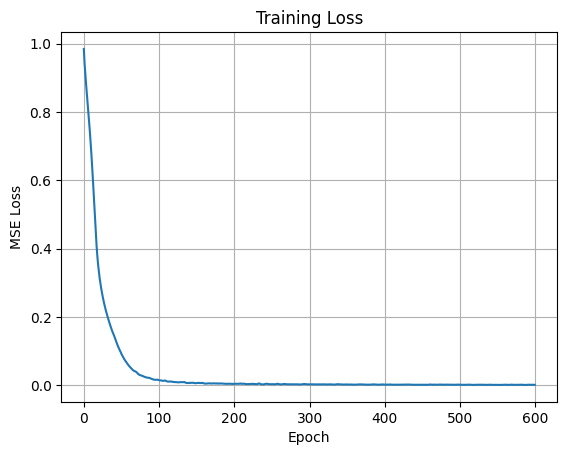

In [79]:
train_losses = []
epochs = 600

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_t)
    loss = criterion(output, Y_train_t)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

## Test

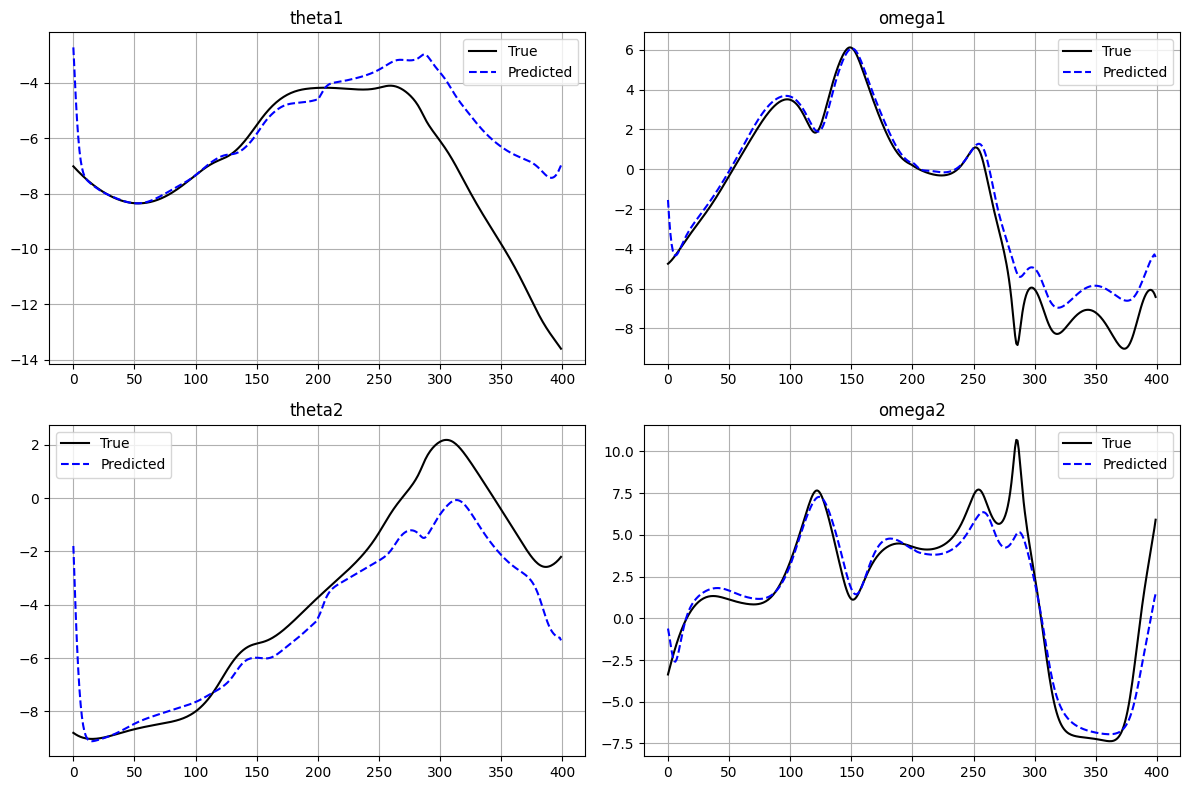

In [80]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_t).squeeze(0).numpy()
    y_pred_test = model(X_test_t).squeeze(0).numpy()

# Inverse transform
y_pred_train_unscaled = scaler_Y.inverse_transform(y_pred_train)
y_pred_test_unscaled = scaler_Y.inverse_transform(y_pred_test)
y_true_test_unscaled = scaler_Y.inverse_transform(Y_test_t.squeeze(0).numpy())

labels = ['theta1', 'omega1', 'theta2', 'omega2']
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true_test_unscaled[:, i], label='True', color='black')
    plt.plot(y_pred_test_unscaled[:, i], '--', label='Predicted', color='blue')
    plt.title(labels[i])
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [81]:
torch.save(model.state_dict(), '/content/drive/MyDrive/lstm_model.pth')

In [158]:

model = LSTMModel(input_size=5, hidden_size=64, output_size=4, num_layers=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/lstm_model.pth'))
model.eval()

LSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

## Sawtooth torque test

Sawtooth Torque Test MSE Loss: 0.017242


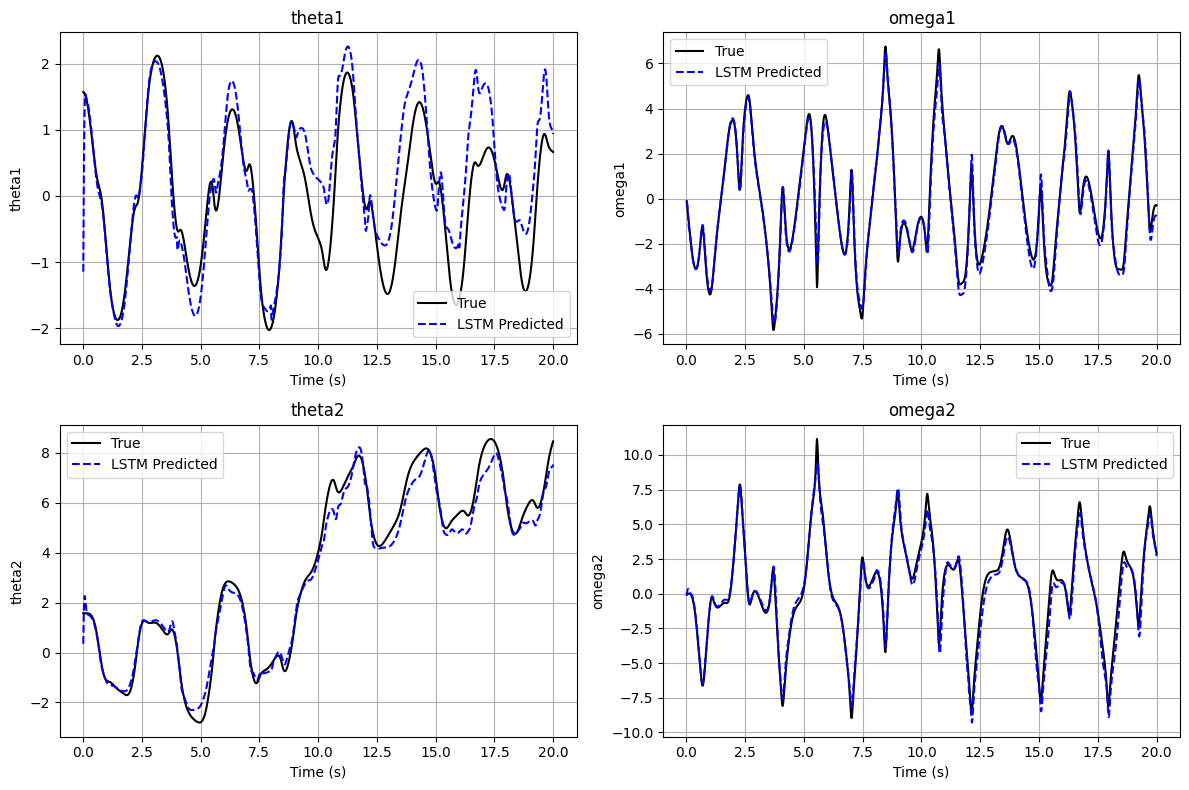

In [159]:

def torque_input_saw(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N·m
    return amplitude * sawtooth(2 * np.pi * freq * t)

def double_pendulum_saw(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input_saw(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1 ** 2 * np.sin(delta) * np.cos(delta)
        + m2 * g * np.sin(theta2) * np.cos(delta)
        + m2 * L2 * omega2 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta1)
        + tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2 ** 2 * np.sin(delta) * np.cos(delta)
        + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
        - (m1 + m2) * L1 * omega1 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]

# Initial conditions and time
y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)

# Simulate system with sawtooth torque
sol = solve_ivp(double_pendulum_saw, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1_s, omega1_s, theta2_s, omega2_s = sol.y
Y_true_saw = np.column_stack([theta1_s, omega1_s, theta2_s, omega2_s])
torque_saw = np.array([torque_input_saw(t) for t in t_eval])

# Create input X = [torque, theta1, omega1, theta2, omega2]
X_saw = np.column_stack([
    torque_saw[1:],
    theta1_s[:-1], omega1_s[:-1],
    theta2_s[:-1], omega2_s[:-1]
])

# Scale using same scalers used in training
X_saw_scaled = scaler_X.transform(X_saw)

# Reshape to LSTM format: (batch, seq_len, features)
X_saw_seq = X_saw_scaled.reshape(1, X_saw_scaled.shape[0], X_saw_scaled.shape[1])
X_saw_torch = torch.tensor(X_saw_seq, dtype=torch.float32)

model.eval()
with torch.no_grad():
    Y_pred_scaled = model(X_saw_torch).squeeze(0).numpy()

# Inverse transform to get physical values
Y_pred_saw = scaler_Y.inverse_transform(Y_pred_scaled)

from torch.nn import MSELoss
# Prepare true output (scaled)
Y_true_saw_shifted = Y_true_saw[1:]  # Skip first time step to align with X_saw
Y_true_saw_scaled = scaler_Y.transform(Y_true_saw_shifted)

Y_pred_tensor = torch.tensor(Y_pred_scaled, dtype=torch.float32)
Y_true_tensor = torch.tensor(Y_true_saw_scaled, dtype=torch.float32)

mse = MSELoss()
mse_loss = mse(Y_pred_tensor, Y_true_tensor).item()
print(f"Sawtooth Torque Test MSE Loss: {mse_loss:.6f}")


plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(t_eval[1:], Y_true_saw[1:, i], label='True', color='black')
    plt.plot(t_eval[1:], Y_pred_saw[:, i], '--', label='LSTM Predicted', color='blue')
    plt.title(labels[i])
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## LSTM Results
as you can see had a huge grow in performance and all of this ia thanks to LSTM with its memory.
Sawtooth Torque Test MSE Loss: 0.017242

# BLSTM

## Model

In [136]:
class BLSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, output_size=4, num_layers=1):
        super(BLSTMModel, self).__init__()
        self.blstm = nn.LSTM(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply hidden size by 2 for bidirectional

    def forward(self, x):
        lstm_out, _ = self.blstm(x)  # lstm_out: (batch, seq_len, hidden_size*2)
        output = self.fc(lstm_out)   # apply FC at each time step
        return output

model = BLSTMModel(input_size=5, hidden_size=128, output_size=4, num_layers=2)



Epoch 0: Loss = 0.000299
Epoch 10: Loss = 0.000293
Epoch 20: Loss = 0.000257
Epoch 30: Loss = 0.000296
Epoch 40: Loss = 0.000247
Epoch 50: Loss = 0.000314
Epoch 60: Loss = 0.000269
Epoch 70: Loss = 0.000327
Epoch 80: Loss = 0.000238
Epoch 90: Loss = 0.000237


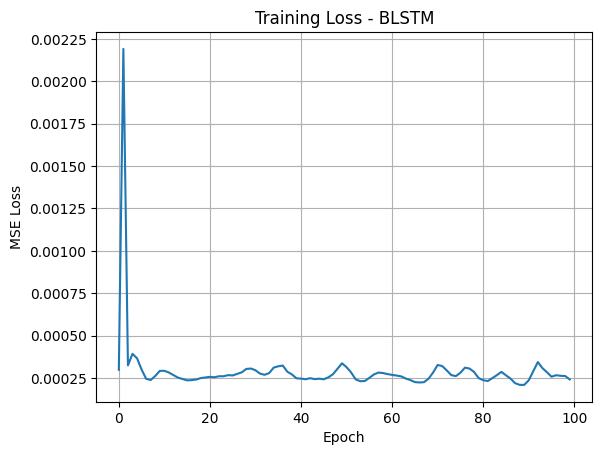

In [145]:
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.9)
train_losses = []
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_t)
    loss = criterion(output, Y_train_t)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss - BLSTM")
plt.grid(True)
plt.show()

## test

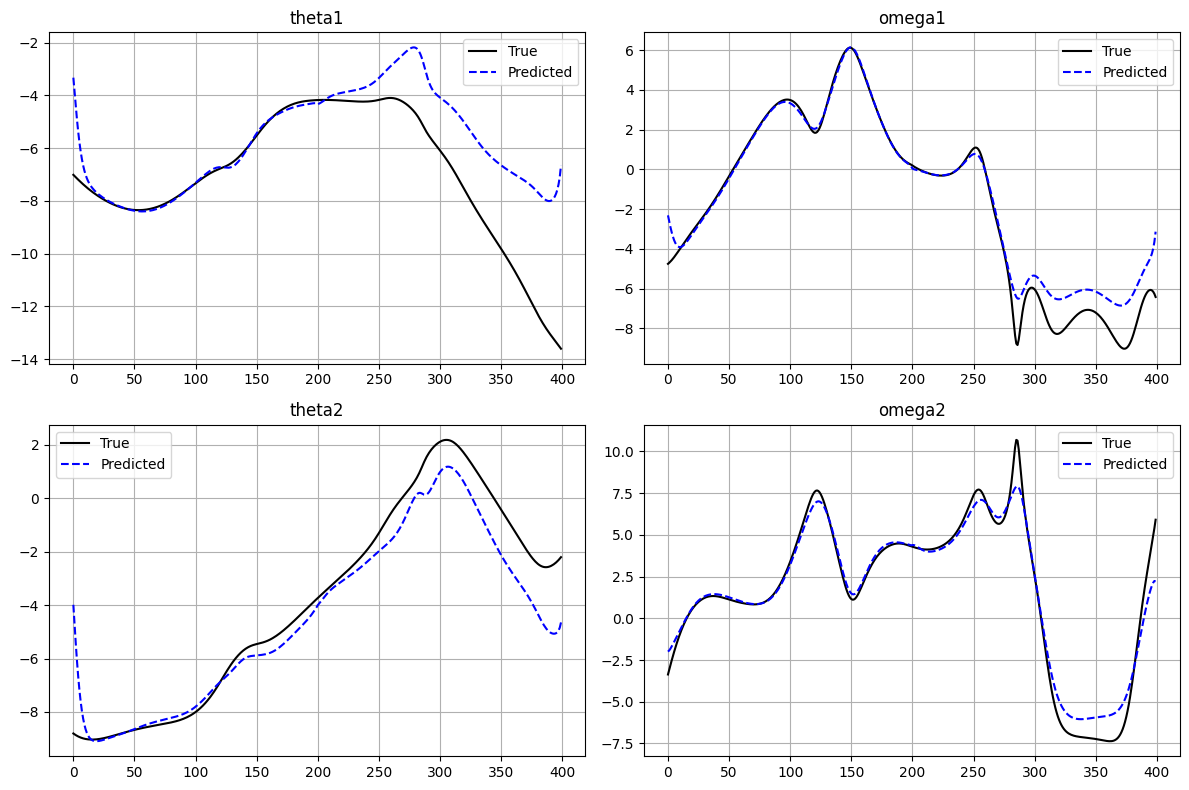

In [146]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_t).squeeze(0).numpy()
    y_pred_test = model(X_test_t).squeeze(0).numpy()

# Inverse transform
y_pred_train_unscaled = scaler_Y.inverse_transform(y_pred_train)
y_pred_test_unscaled = scaler_Y.inverse_transform(y_pred_test)
y_true_test_unscaled = scaler_Y.inverse_transform(Y_test_t.squeeze(0).numpy())

labels = ['theta1', 'omega1', 'theta2', 'omega2']
plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true_test_unscaled[:, i], label='True', color='black')
    plt.plot(y_pred_test_unscaled[:, i], '--', label='Predicted', color='blue')
    plt.title(labels[i])
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [121]:
torch.save(model.state_dict(), '/content/drive/MyDrive/blstm_model.pth')

In [155]:

model = BLSTMModel(input_size=5, hidden_size=128, output_size=4, num_layers=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/blstm_model.pth'))
model.eval()

BLSTMModel(
  (blstm): LSTM(5, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

## Sawtooth torque test

Sawtooth Torque Test Loss (MSE): 0.013025


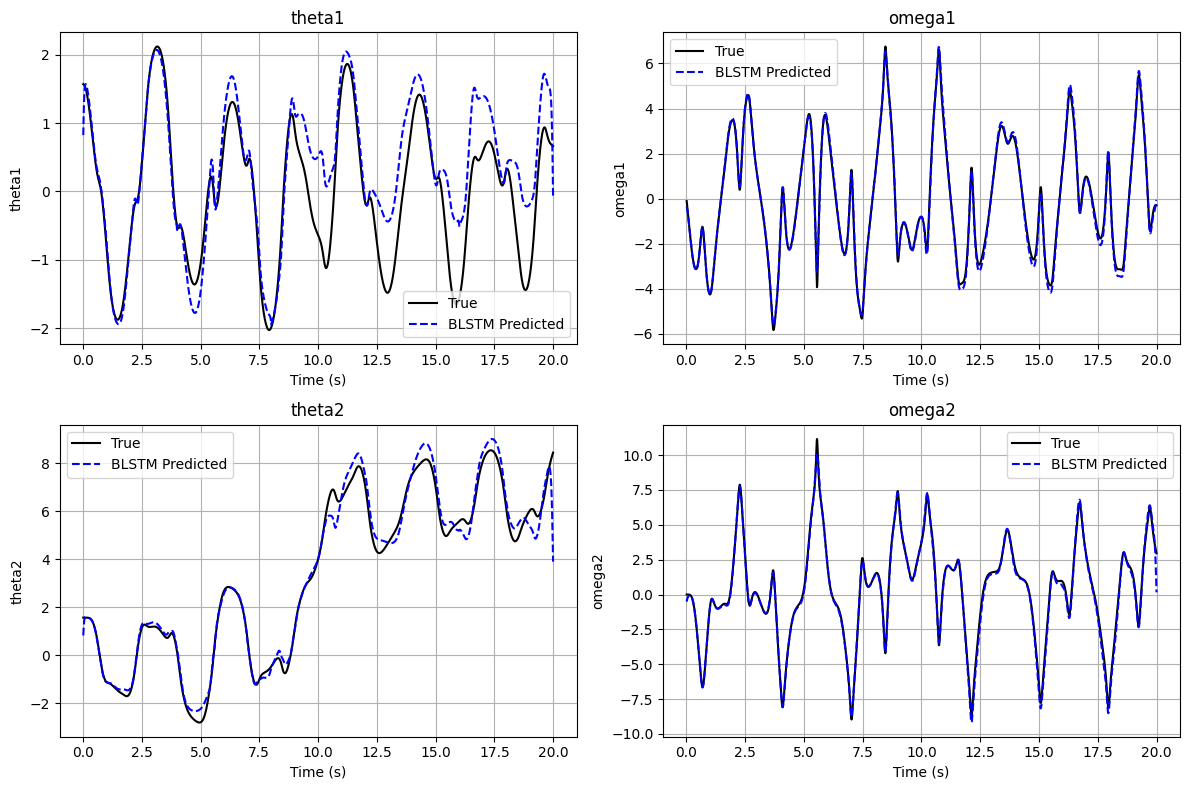

In [156]:


def torque_input_saw(t):
    freq = 0.25
    amplitude = 1.0
    return amplitude * sawtooth(2 * np.pi * freq * t)

def double_pendulum_saw(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input_saw(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1 ** 2 * np.sin(delta) * np.cos(delta)
        + m2 * g * np.sin(theta2) * np.cos(delta)
        + m2 * L2 * omega2 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta1)
        + tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2 ** 2 * np.sin(delta) * np.cos(delta)
        + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
        - (m1 + m2) * L1 * omega1 ** 2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]

# Simulate
y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(*t_span, 2000)
sol = solve_ivp(double_pendulum_saw, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1_s, omega1_s, theta2_s, omega2_s = sol.y
Y_true_saw = np.column_stack([theta1_s, omega1_s, theta2_s, omega2_s])
torque_saw = np.array([torque_input_saw(t) for t in t_eval])

# Preprocess input
X_saw = np.column_stack([
    torque_saw[1:],
    theta1_s[:-1], omega1_s[:-1],
    theta2_s[:-1], omega2_s[:-1]
])
X_saw_scaled = scaler_X.transform(X_saw)
X_saw_seq = X_saw_scaled.reshape(1, X_saw_scaled.shape[0], X_saw_scaled.shape[1])
X_saw_torch = torch.tensor(X_saw_seq, dtype=torch.float32)

model.eval()
with torch.no_grad():
    Y_pred_scaled = model(X_saw_torch).squeeze(0).numpy()

Y_pred_saw = scaler_Y.inverse_transform(Y_pred_scaled)



# Prepare true outputs (Y_true_saw) for comparison
Y_true_saw_shifted = Y_true_saw[1:]  # match the predicted sequence length
Y_true_saw_scaled = scaler_Y.transform(Y_true_saw_shifted)

# Convert to torch tensors
Y_true_tensor = torch.tensor(Y_true_saw_scaled, dtype=torch.float32)
Y_pred_tensor = torch.tensor(Y_pred_scaled, dtype=torch.float32)

# Compute and print MSE loss
criterion = torch.nn.MSELoss()
loss = criterion(Y_pred_tensor, Y_true_tensor)
print(f"Sawtooth Torque Test Loss (MSE): {loss.item():.6f}")

plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(t_eval[1:], Y_true_saw[1:, i], label='True', color='black')
    plt.plot(t_eval[1:], Y_pred_saw[:, i], '--', label='BLSTM Predicted', color='blue')
    plt.title(labels[i])
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## BLSTM Results

BLSTM did not made any difference in this modelling problem. the results are similar to LSTM.
test loss on sawtooth torque : 0.013025

# Transformers

In [160]:
# Reshape: (batch, seq_len, features)
X_train_seq = X_train_scaled.reshape(1, X_train_scaled.shape[0], X_train_scaled.shape[1])
Y_train_seq = Y_train_scaled.reshape(1, Y_train_scaled.shape[0], Y_train_scaled.shape[1])

X_test_seq = X_test_scaled.reshape(1, X_test_scaled.shape[0], X_test_scaled.shape[1])
Y_test_seq = Y_test_scaled.reshape(1, Y_test_scaled.shape[0], Y_test_scaled.shape[1])

# Positional encoding
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, None]
    i = np.arange(d_model)[None, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angles = pos * angle_rates
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])
    return torch.tensor(pe, dtype=torch.float32)

In [163]:
# Model
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pe = positional_encoding(2000, d_model).unsqueeze(0)  # max len = 2000
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.input_proj(x) + self.pe[:, :x.size(1), :].to(x.device)
        x = self.transformer(x)
        return self.output_proj(x)

# Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(5, 4).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 20, Loss: 0.084394
Epoch 40, Loss: 0.037693
Epoch 60, Loss: 0.024087
Epoch 80, Loss: 0.019081
Epoch 100, Loss: 0.016722
Epoch 120, Loss: 0.014803
Epoch 140, Loss: 0.012553
Epoch 160, Loss: 0.011428
Epoch 180, Loss: 0.009958
Epoch 200, Loss: 0.009241
Epoch 220, Loss: 0.008256
Epoch 240, Loss: 0.007954
Epoch 260, Loss: 0.007650
Epoch 280, Loss: 0.006939
Epoch 300, Loss: 0.006200


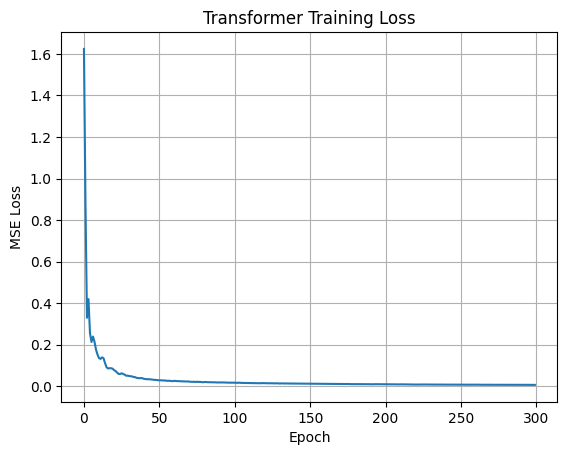

In [164]:

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train_seq, dtype=torch.float32).to(device)

losses = []
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, Y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Transformer Training Loss')
plt.grid()
plt.show()

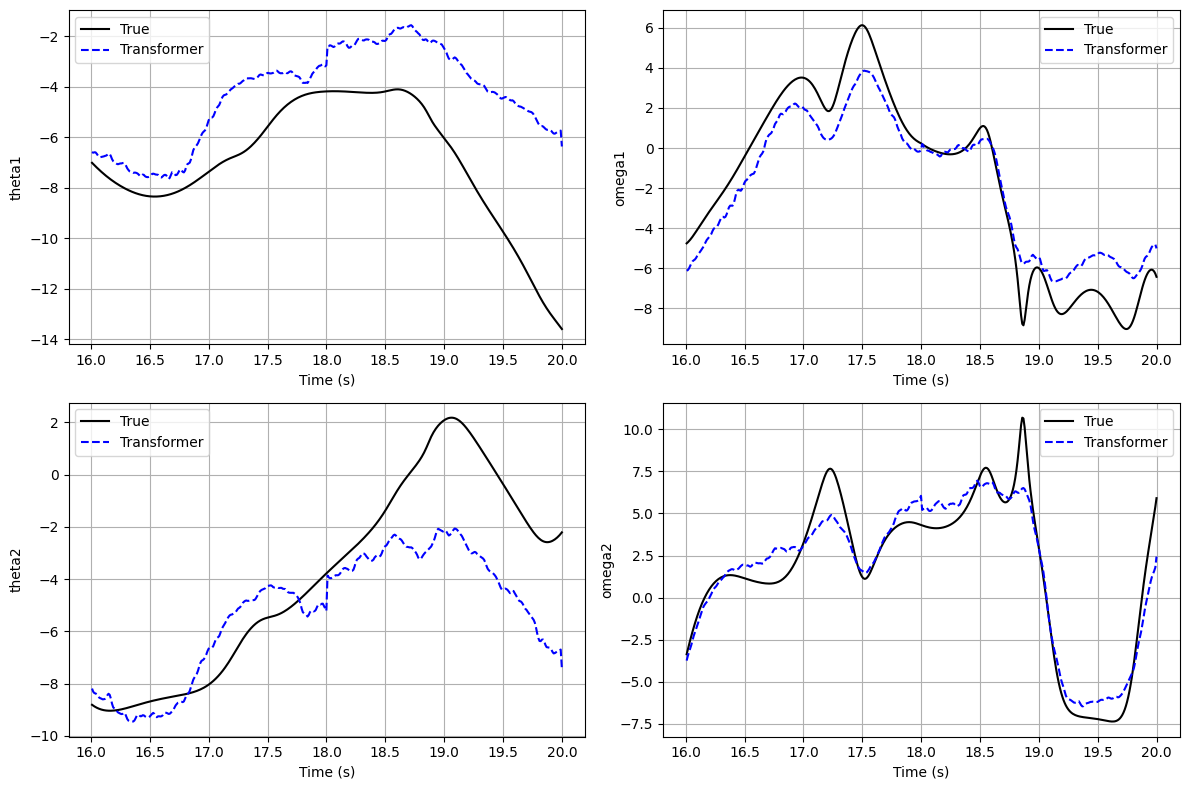

In [162]:
# Test
def test_model(model, X_seq, Y_seq, scaler_Y):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
        Y_pred_scaled = model(X_tensor).cpu().squeeze(0).numpy()
    return scaler_Y.inverse_transform(Y_pred_scaled)

Y_pred_test = test_model(model, X_test_seq, Y_test_seq, scaler_Y)
Y_true_test = scaler_Y.inverse_transform(Y_test_seq.squeeze(0))

# Plot test
plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']
time = t_eval[split_idx+1:]
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(time, Y_true_test[:, i], label='True', color='black')
    plt.plot(time, Y_pred_test[:, i], '--', label='Transformer', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()
